In [7]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re
label_encoder = LabelEncoder()


# 1) Consider the dataset ‘noisy_data.csv’ and apply the following pre-processing techniques and obtain the clean dataset.

In [8]:
dataset = pd.read_csv("./Data/noisy_data.csv")

In [9]:
dataset.head()

,Region,Age,Income,Online Shopper
0,India,49.0,86400.0,No
1,Brazil,32.0,57600.0,Yes
2,USA,35.0,64800.0,No
3,Brazil,43.0,73200.0,No
4,USA,45.0,NaN,Yes


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          10 non-null     object 
 1   Age             9 non-null      float64
 2   Income          9 non-null      float64
 3   Online Shopper  10 non-null     object 
dtypes: float64(2), object(2)
memory usage: 452.0+ bytes


In [11]:
dataset.isna().sum()

Region            0
Age               1
Income            1
Online Shopper    0
dtype: int64

### Handling missing values by imputation for age.

In [16]:
# for age using KNN imputation
imputer = KNNImputer(n_neighbors=3)
dataset['Age'] = imputer.fit_transform(dataset[['Age']])

In [13]:
dataset.isna().sum()

Region            0
Age               0
Income            1
Online Shopper    0
dtype: int64

In [14]:
# Now using Linear regression to predict Income for the age as a feature to predict income
ageAndIncomeDataset = dataset.drop(["Region", "Online Shopper"],axis=1)

LrModel = LinearRegression()

missing_income_dataset = ageAndIncomeDataset[ageAndIncomeDataset['Income'].isnull()]
ageAndIncomeDatasetWithoutNullIncome = ageAndIncomeDataset.dropna(subset=['Income'])

feature = ageAndIncomeDatasetWithoutNullIncome[['Age']]
target = ageAndIncomeDatasetWithoutNullIncome['Income']
LrModel.fit(feature, target)

featuresToPredict = missing_income_dataset[['Age']]
targetPredict = LrModel.predict(featuresToPredict)
dataset.loc[missing_income_dataset.index, 'Income'] = targetPredict

In [15]:
dataset.isna().sum()

Region            0
Age               0
Income            0
Online Shopper    0
dtype: int64

*Missing Income is fullfilled using linear regression model using age as the feature.*

### Apply Normality tests to numerical columns and state the hypothesis clearly and comment on the normality of the data.

*We have Age and Income column as numerical columns so applying normality test for these two.*

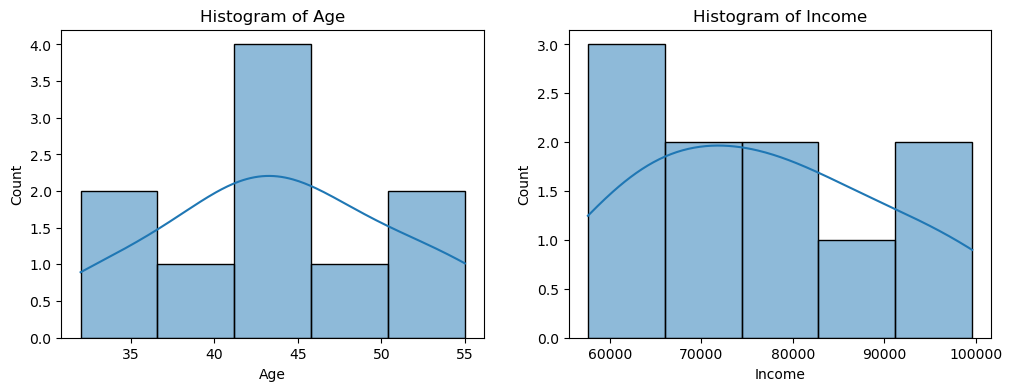

In [43]:
# Checking the normality with the histogram plot with the kde.

def histPlot(data, title, plotarea ):
  plt.subplot(1, 2, plotarea + 1)
  sns.histplot(data, kde=True)
  plt.title(f'Histogram of {title}')

plt.figure(figsize=(12, 4))
for index, value in enumerate(["Age","Income"]):
  histPlot(dataset[value], value, index)
plt.show()

*The graph and distribution from the kde and histogram follows the bell-shaped structure which denotes that both of the feature follows the normal distribution however the right and left part are not visible that means the data may be corrupt or truncated, we cannot fully depend on it.*

In [13]:
# Test for normality using this method (Anderson-Darling Test):
def andersonDarlingTest(data, key):
  anderson_stat, anderson_critical_values, _ = stats.anderson(data, dist='norm')
  if anderson_stat < anderson_critical_values[2]:
    print(f"{key} follows a normal distribution or null hypothesis(H0)")
  else:
    print(f"{key} Data does not follow a normal distribution or alternate hypothesis(H1))")

for key in ["Age","Income"]:
  andersonDarlingTest(dataset[key], key)

Age follows a normal distribution or null hypothesis(H0)
Income follows a normal distribution or null hypothesis(H0)


*From the above test, we can conclude that both follows null hypothesis which means the values are accepted to follow the normal distribution.*

### Apply encodings for categorical variable and scale the features.

In [45]:
# using label encoder to encode the Online shopper
def labelEncoder(key):
  print(dataset[key].unique())
  dataset[key] = label_encoder.fit_transform(dataset[key])
  print(dataset[key].unique())

for key in ["Region","Online Shopper"]:
  labelEncoder(key)

['India' 'Brazil' 'USA']
[1 0 2]
['No' 'Yes']
[0 1]


In [46]:
dataset.head()

,Region,Age,Income,Online Shopper
0,1,49.0,86400.000000,0
1,0,32.0,57600.000000,1
2,2,35.0,64800.000000,0
3,0,43.0,73200.000000,0
4,2,45.0,78912.533284,1


In [47]:
# Applying scaling to the numerical features of our dataset using standard scalar
def scalingData(data, numericalColumns):
  scaler = StandardScaler()
  dataset[numericalColumns] = scaler.fit_transform(data[numericalColumns])

scalingData(dataset, ["Age", "Income"])
print(dataset)


   Region       Age    Income  Online Shopper
0       1  0.758874  0.730328               0
1       0 -1.711504 -1.454115               1
2       2 -1.275555 -0.908004               0
3       0 -0.113024 -0.270875               0
4       2  0.177609  0.162413               1
5       1 -0.548973 -0.543930               1
6       0  0.000000 -1.090041               0
7       1  1.340140  1.367458               1
8       2  1.630773  1.731531               0
9       1 -0.258340  0.275236               1


# 2) Consider the text present in the file ‘wiki.txt’ and Answer the following questions :

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aacic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aacic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Write a program to convert following text into tokens with two tokenization methods such as ‘RegexpTokenizer()’ and ‘word_tokenize()’ from NLTK library. (Note :The tokens should not have stop words and punctuation symbols. Feel free to decide about the correct list of stop words; e.g., negative words (don’t) could be important for you. Execute both methods of tokenization along with your code of removing stop words and punctuation.)

In [4]:
delimiter = '\t'
wikiData = pd.read_csv("./Data/wiki.txt", delimiter=delimiter, header=None, names=["Text"])
wikiData.head()

,Text
0,The history of NLP generally started in the 19...
1,The Georgetown experiment in 1954 involved ful...
2,Some notably successful NLP systems developed ...


In [5]:
# Applying regexp tokenizer and word tokenizer for the extracted text
def wordTokenizer(text):
    tokens = word_tokenize(text)
    return tokens

def regexpTokenizer(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

def yearRemover(text):
    newText = re.sub(r'\d{4}', ' ', text)
    return newText

def cleanTheText(words):
    stop_words = set(stopwords.words('english'))
    custom_stop_words = ["''", '``']
    return [word for word in words if word.lower() not in stop_words and word.lower() not in custom_stop_words and word.lower() not in string.punctuation]

def stemming(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatization(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

wikiData['Text'] = wikiData['Text'].str.lower()
wikiData['AltText'] = wikiData['Text']
wikiData['Text'] = wikiData['Text'].apply(yearRemover)
wikiData['Text'] = wikiData['Text'].apply(stemming)
wikiData['Text'] = wikiData['Text'].apply(lemmatization)

fields = ["Tokens_word", "Tokens_reg"]

wikiData["Tokens_word"] = wikiData['Text'].apply(wordTokenizer)
wikiData["Tokens_reg"] = wikiData['Text'].apply(regexpTokenizer)

for value in fields:
    wikiData[value] = wikiData[value].apply(cleanTheText)

print(f"from word tokenizer {wikiData['Tokens_word'][0]}\n")
print(f"from reg tokenizer {wikiData['Tokens_reg'][0]}\n")
print(f"from word tokenizer {wikiData['Tokens_word'][1]}\n")
print(f"from reg tokenizer {wikiData['Tokens_reg'][1]}\n")
print(f"from word tokenizer {wikiData['Tokens_word'][2]}\n")
print(f"from reg tokenizer {wikiData['Tokens_reg'][2]}")


from word tokenizer ['histori', 'nlp', 'gener', 'start', 'although', 'work', 'found', 'earlier', 'periods', 'alan', 'ture', 'publish', 'articl', 'titl', 'comput', 'machineri', 'intelligence', 'propos', 'call', 'ture', 'test', 'criterion', 'intelligence']

from reg tokenizer ['histori', 'nlp', 'gener', 'start', 'although', 'work', 'found', 'earlier', 'periods', 'alan', 'ture', 'publish', 'articl', 'titl', 'comput', 'machineri', 'intelligence', 'propos', 'call', 'ture', 'test', 'criterion', 'intelligence']

from word tokenizer ['georgetown', 'experi', 'involv', 'fulli', 'automat', 'translat', 'sixti', 'russian', 'sentenc', 'english', 'author', 'claim', 'within', 'three', 'five', 'years', 'machin', 'translat', 'would', 'solv', 'problem', '2', 'however', 'real', 'progress', 'wa', 'much', 'slower', 'alpac', 'report', 'found', 'ten-year-long', 'research', 'fail', 'fulfil', 'expectations', 'fund', 'machin', 'translat', 'wa', 'dramat', 'reduced', 'littl', 'research', 'machin', 'translat', 'wa'

### Write a regular expression to extract all the year mentions in the ‘wiki.txt’ file.

In [6]:
def extract_years(text):
    years = re.findall(r'\d{4}', text)
    return years

wikiData['Years'] = wikiData['AltText'].apply(extract_years)

years = wikiData['Years'].explode()

years.unique()


array(['1950', '1954', '1966', '1980', '1960', '1964'], dtype=object)

### State the differences observed in the output of tokenization methods.

*The only difference I analyzed in the result of the two tokenizer functions is treating words like "natural-language". The word_tokenize treats the word as a single word whilst the regexpTokenize was making two words out of it. Except both have same tokens.*

In [52]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression
import numpy as np

# 3) Consider this dataset from kaggle. (Download the dataset from following link : https://www.kaggle.com/dansbecker/melbourne-housing-snapshot/home) and answer the following questions :

In [53]:
melbHousingData = pd.read_csv("./Data/melb_data.csv")
melbHousingData.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [54]:
melbHousingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [55]:
melbHousingDataFeatures = melbHousingData.drop('Price' , axis=1)
target = melbHousingData['Price']

numericalColumns = melbHousingDataFeatures.select_dtypes(include=['float64','int64']).columns
categoricalColumns = melbHousingDataFeatures.select_dtypes(include=['object']).columns

melbHousingNumericalFeatures = melbHousingDataFeatures.drop(categoricalColumns, axis=1)
melbHousingCategoricalFeatures = melbHousingDataFeatures.drop(numericalColumns, axis=1)
melbHousingCategoricalFeatures.drop('Date', axis=1, inplace=True)

melbHousingCategoricalFeatures['CouncilArea'].fillna('Unknown', inplace=True)
melbHousingNumericalFeatures.info()
melbHousingCategoricalFeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          13580 non-null  int64  
 1   Distance       13580 non-null  float64
 2   Postcode       13580 non-null  float64
 3   Bedroom2       13580 non-null  float64
 4   Bathroom       13580 non-null  float64
 5   Car            13518 non-null  float64
 6   Landsize       13580 non-null  float64
 7   BuildingArea   7130 non-null   float64
 8   YearBuilt      8205 non-null   float64
 9   Lattitude      13580 non-null  float64
 10  Longtitude     13580 non-null  float64
 11  Propertycount  13580 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Suburb       13580 non-null  

### Apply the feature selection techniques over the melbourne-housing dataset namely:
- Correlation
- Chi-Square
- Mutual-Information
- Random Forest feature importance

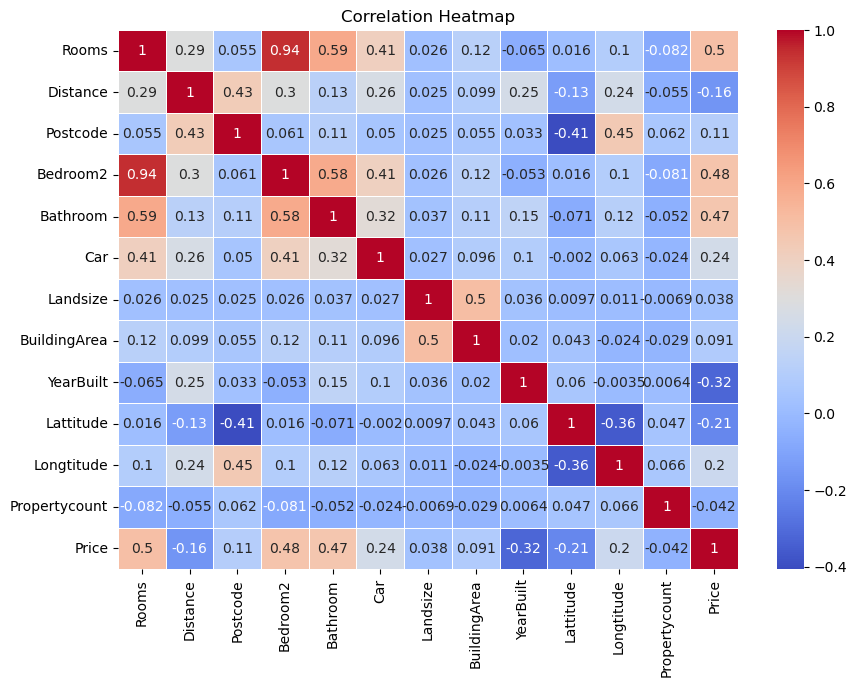

In [56]:
# Applying correlation method to the numerical dataset and analyzing using price as the target

melbHousingNumericalFeaturesWithPrice = pd.concat([melbHousingNumericalFeatures, target], axis=1)
correlation_matrix = melbHousingNumericalFeaturesWithPrice.corr(method='pearson')

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

*Taking into consideration price as the target. price shows high correlation with room ,bathroom and bedroom2. Furthermore, the room, bathroom and bedroom2 are correlated with each other. so from this heatmap, we can summarize that we can either remove one or two among the three or can merge those to create new feature like total rooms bedetc. Propertycount doesnot have any correlation with other variables; we can also ignore this column. Building area and landsize have some correlation with each other but does not have any effect to other variables and price too, so we can also ignore these variables.Building and landsize are also correlated and as building area has lots of missing values, and is not correlated with price, so we can drop these too.*

In [57]:
melbHousingNumericalFeatures.isnull().sum()

Rooms               0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
Lattitude           0
Longtitude          0
Propertycount       0
dtype: int64

In [58]:
# For removing null rows for Car and YearBuilt
melbHousingNumericalFeatures = pd.concat([melbHousingNumericalFeatures, target], axis=1)
# we have minimal effect of BuildingArea and alot of row is missing so I am deleting this feature
melbHousingNumericalFeatures.drop("BuildingArea", axis=1, inplace=True)
melbHousingNumericalFeatures.dropna(subset=['YearBuilt',"Car"], inplace=True)
targetForNumerical = melbHousingNumericalFeatures['Price']
melbHousingNumericalFeatures.drop("Price", axis=1, inplace=True)
melbHousingNumericalFeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8174 entries, 1 to 13579
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          8174 non-null   int64  
 1   Distance       8174 non-null   float64
 2   Postcode       8174 non-null   float64
 3   Bedroom2       8174 non-null   float64
 4   Bathroom       8174 non-null   float64
 5   Car            8174 non-null   float64
 6   Landsize       8174 non-null   float64
 7   YearBuilt      8174 non-null   float64
 8   Lattitude      8174 non-null   float64
 9   Longtitude     8174 non-null   float64
 10  Propertycount  8174 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 766.3 KB


In [59]:
plt.figure(figsize=(10, 6))
def plotBarChart(df, model, type, dfkey):
    plt.bar(range(len(df)), df[dfkey])
    plt.xlabel('Features')
    plt.ylabel('Score')
    plt.title(f'Scores for {type} Features using {model.__name__}')
    plt.xticks(range(len(df)), df['Feature'], rotation=90)
    plt.show()

# Encoding categorical features
for key in melbHousingCategoricalFeatures.columns:
  melbHousingCategoricalFeatures[key] = label_encoder.fit_transform(melbHousingCategoricalFeatures[key])

<Figure size 1000x600 with 0 Axes>

In [60]:
# # Applying chisquare feature selection technique to the catagorical data
# for key in melbHousingCategoricalFeatures.columns:
#   melbHousingCategoricalFeatures[key] = label_encoder.fit_transform(melbHousingCategoricalFeatures[key])

# selector = SelectKBest(score_func=chi2, k='all')

# selector.fit_transform(melbHousingCategoricalFeatures, target)

# # Get chi-square scores and p-values
# chi2_scores = selector.scores_
# p_values = selector.pvalues_

# featureSelected = selector.get_support()
# # np.set_printoptions(threshold=np.inf)
# print("Chi-square scores:", chi2_scores)
# print("P-values:", p_values)
# print("Features selected via chi square:", featureSelected)

*Chi-square test is done only for categorical input and categorical output, chi square test cannot be done for price which is a numerical output. But even if that is true I just gave it a try. we have to use ANOVA or kendalls test for this feature selection test.*

Important features from rfmodel for Categorical features:::::::::::
       Feature  Importance
1      Address    0.486319
0       Suburb    0.179357
4      SellerG    0.177648
5  CouncilArea    0.077951
3       Method    0.033273
6   Regionname    0.027243
2         Type    0.018209


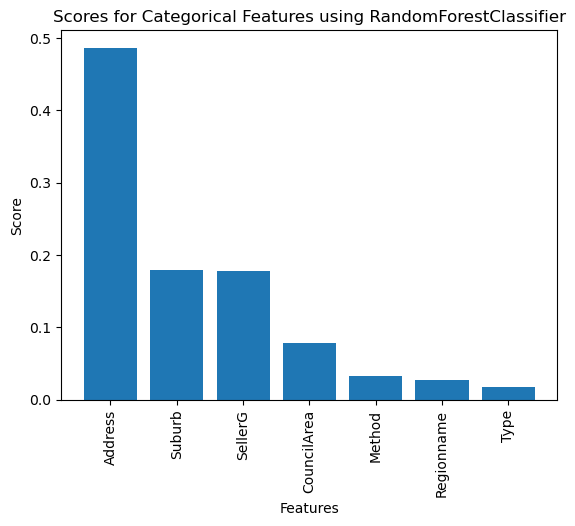

Important features from rfmodel for Numerical features:::::::::::
          Feature  Importance
0           Rooms    0.231289
1        Distance    0.174184
2        Postcode    0.133911
6        Landsize    0.116946
7       YearBuilt    0.112900
9      Longtitude    0.071111
8       Lattitude    0.060728
4        Bathroom    0.041091
10  Propertycount    0.027591
3        Bedroom2    0.016002
5             Car    0.014247


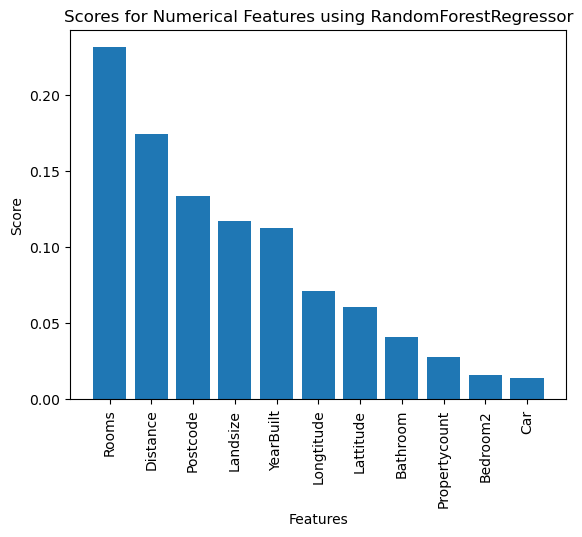

In [61]:
# Using random forest feature importance technique
def randomForestTest(model, x, y, type):
  rfModel = model(n_estimators=10, random_state=42)
  rfModel.fit(x, y)
  importantFeatures = rfModel.feature_importances_
  importantFeatures = pd.DataFrame({'Feature': x.columns, 'Importance': importantFeatures})
  importantFeatures = importantFeatures.sort_values(by='Importance', ascending=False)
  print(f"Important features from rfmodel for {type} features:::::::::::")
  print(f"{importantFeatures}")
  # importantFeatures.plot(kind='bar')
  plotBarChart(importantFeatures, model, type, "Importance")

for index, model in enumerate([RandomForestClassifier, RandomForestRegressor]):
 x = melbHousingNumericalFeatures
 y = targetForNumerical
 type = "Numerical"
 if(index == 0):
   x = melbHousingCategoricalFeatures
   type = "Categorical"
   y = target
 randomForestTest(model, x, y, type)


Selected Features from MI for Categorical features::::::::::::::::::
Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea',
       'Regionname'],
      dtype='object')


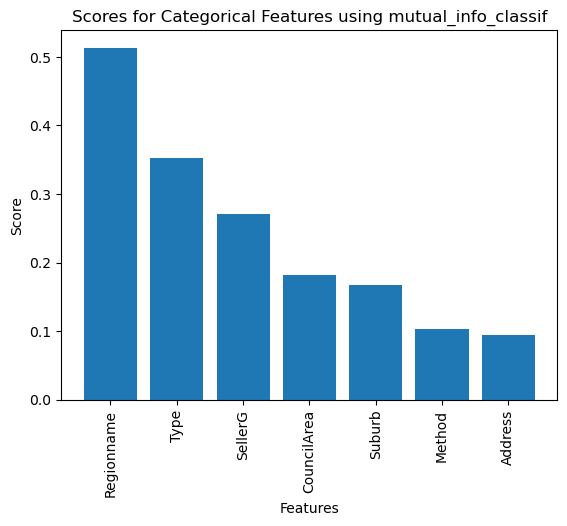

Selected Features from MI for Numerical features::::::::::::::::::
Index(['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'],
      dtype='object')


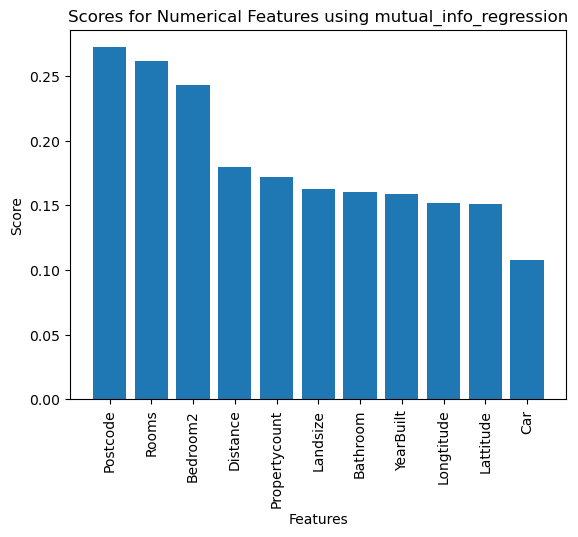

In [62]:
# Using mutual-information technique
def mutualInformationTest(model, x, y, type):
    miSelector = SelectKBest(score_func=model, k= "all")
    miSelector.fit_transform(x, y)
    selectedFeaturesIndex = miSelector.get_support(indices=True)
    selectedFeatures = x.columns[selectedFeaturesIndex]
    miScores = miSelector.scores_
    importantFeatures = pd.DataFrame({'Feature': x.columns, 'MI Score': miScores})
    importantFeatures = importantFeatures.sort_values(by='MI Score', ascending=False)
    print(f"Selected Features from MI for {type} features::::::::::::::::::")
    print(selectedFeatures)
    plotBarChart(importantFeatures, model, type, "MI Score")


for index, model in enumerate([mutual_info_classif, mutual_info_regression]):
    x = melbHousingNumericalFeatures
    y = targetForNumerical
    type = "Numerical"
    if(index == 0):
        x = melbHousingCategoricalFeatures
        type = "Categorical"
        y = target
    mutualInformationTest(model, x, y, type)

### Compare the importance of selected features using bar chart.
*For numerical variables, Correlation showed high correlation of price with the rooms , the result of rain forest also denotes the same thing but surprisingly mututal information is showing postcode before rooms as important feature. similarly, correlation is showing landsize as the less correlated while rain forest and mutual information both are showing car as the least prio variable. For categorical features, rain forest gives address as the high and Type as the lowest whilst mutual information says Regionname as the highest and method as the lowest impacters.*

### Comment on the results obtained from various feature selection techniques and which is the best and worst feature selection technique on the given dataset.
*It was given 4 methods to try on the melbourne housing snapshot for feature selection, first one is the correlation which is a satistical method to compare the impact of other variables with each other. I have plot a correlation heatmap to analyse the data and remove the unwanted features. We can only use this method to numerical features.*
*Second one is the chi square, I tried to implement this feature selection method but the result was not so good as we need a categorical output for the application of chi square and Price was our target which is a numerical feature*
*Third and fourth one is mutual-information and rainforest, these techniques also supports mixed type dataset. However, I seperated the data into categorical and numerical features to carry out the test. Both ane time consuming methods but gives result with proper scores. I limited the rain forest to n_estimators = 10 after getting memory allocation issue for default setting which completed in 14.8 sec along with printing barchart. On the other hand, mutual information did not gave such issue but it was taking 10-11 mins to complete.*

*From the methods above, I think rainforest is more flexible technique whereas all methods have its own limitation and application, I will not say worst but we have to wait alot for mutual Information,we cannot see correlation of categorical features in correlation technique, and we cannot use chi square for numerical output.*